Programming excercises from Rasmussen and Williams GP book

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
from scipy.special import expit as sigmoid

In [2]:
def rbf_kernel(x_1, x_2):
    """Return covariance kernel exp(-1/2|x_1p - x_2q|**2) for two vectors x_1, x_2"""
    sq_dist = np.sum(x_1**2, 1).reshape(-1, 1) + np.sum(x_2**2, 1) - 2*np.dot(x_1, x_2.T)
    return np.exp(-(0.5) * sq_dist) 

In [3]:
def Gaussian(mean, cov, num_samples):
    L = np.linalg.cholesky(cov + 1e-6*np.eye(cov.shape[0]))
    samples = np.random.multivariate_normal(np.zeros(mean.shape), np.eye(cov.shape[0]), size=num_samples)
    return mean[:,None] + np.dot(L,samples.T)

## Laplace Method

In [4]:
def mode_finding_laplace(cov, y, lk_fn, max_iters=10):
       
    f = np.zeros_like(y)
    obj = 0
    for i in range(max_iters):
        W = -lk_fn(y,f)[2]
        W_sqrt = W**(1/2)
        L = np.linalg.cholesky(np.eye(y.shape[0]) + (W_sqrt).dot(cov).dot(W_sqrt))

        b = W.dot(f) + lk_fn(y,f)[1]

        a = b - (W_sqrt).dot(np.linalg.solve(L.T,np.linalg.solve(L,(W_sqrt).dot(cov).dot(b))))

        f = cov.dot(a)
        
        if (np.abs(obj - (-1/2 * a.T.dot(f) + lk_fn(y,f)[0])) < 1e-9).any():
            break
        obj = (-1/2 * a.T.dot(f) + lk_fn(y,f)[0])
                
    log_q = -1/2 * a.T.dot(f) + lk_fn(y,f)[0] - np.trace(L)
    
    return f, log_q

In [5]:
def laplace_predictions(mode, X, y, k, lk_fn, x_star):
    W = -lk_fn(y,mode)[2]
    W_sqrt = W**(1/2)
    L = np.linalg.cholesky(np.eye(y.shape[0]) + (W_sqrt).dot(cov).dot(W_sqrt))
    pi_stars = []
    for x_s in x_star:
        x_s = np.array(x_s).reshape(1,-1)
        f_star = k(X,x_s).T.dot(lk_fn(y,mode)[1])
        v = np.linalg.solve(L,W_sqrt.dot(k(X,x_s)))
        var_f = k(x_s,x_s) - v.T.dot(v)

        pi_star = sum([sigmoid(z) for z in Gaussian(f_star,var_f, 1000)[0,:]])/1000
        pi_stars.append(pi_star)
        
    return pi_stars

In [6]:
def sigmoid_lf_fn(y,f):
    '''
    returns likelihood function and first and second derivatives
    '''
    t = (y+1)/2
    pi = sigmoid(f)
    
    
    lk = -np.log(1 + np.exp(-y * f))
    d_lk = (t-pi)
    d2_lk = -np.diag((pi*(1-pi)).ravel())

    
    return lk, d_lk, d2_lk

In [7]:
def normal_cdf_lf_fn(y,f):
    '''
    returns likelihood function and first and second derivatives
    '''
    t = (y+1)/2
    pi = norm.cdf(f)

    
    lk = np.log(norm.cdf(y*f))
    d_lk = y * norm.pdf(f) / norm.cdf(y*f)
    d2_lk = np.diag((-norm.pdf(f)**2 / norm.cdf(y*f)**2 - y * f * norm.pdf(f) / norm.cdf(y*f)).ravel())
    
    return lk, d_lk, d2_lk

In [8]:
def generate_dataset(size, classes=2, noise=0.5):
    # Generate random datapoints
    labels = np.random.randint(0, classes, size)
    x = (np.random.rand(size) + labels) / classes
    y = x + np.random.rand(size) * noise
    # Reshape data in order to merge them
    x = x.reshape(size, 1)
    y = y.reshape(size, 1)
    labels = labels.reshape(size, 1)
    # Merge the data
    data = np.hstack((x, y, labels))
    return data

### Sigmoid Likelihood Function

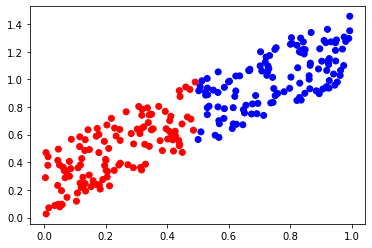

In [29]:
data = generate_dataset(500)
x_1 = data[:250,0]
x_2 = data[:250,1]
X = data[:250,:2]
y = data[:250,2]
y[y==0] = -1
plt.scatter(x_1,x_2,c=y,cmap=matplotlib.colors.ListedColormap(['red', 'blue']))

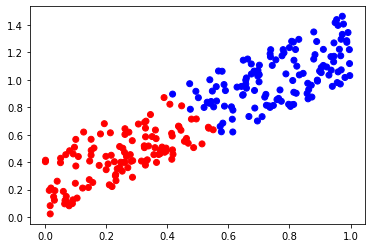

In [30]:
cov = rbf_kernel(X,X)

mode, log_q = mode_finding_laplace(cov, y, sigmoid_lf_fn)

#test = generate_dataset(50)

test_x = data[250:,:2]

pi = laplace_predictions(mode, X, y, rbf_kernel, sigmoid_lf_fn, test_x)




x_1 = test_x[:,0]
x_2 = test_x[:,1]

y = np.array(pi)
y[y>0.5] = 1
y[y<=0.5] = -1
plt.scatter(x_1,x_2,c=y,cmap=matplotlib.colors.ListedColormap(['red', 'blue']))

### Probit Likelihood Function

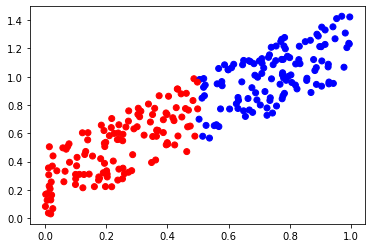

In [31]:
data = generate_dataset(500)
x_1 = data[:250,0]
x_2 = data[:250,1]
X = data[:250,:2]
y = data[:250,2]
y[y==0] = -1
plt.scatter(x_1,x_2,c=y,cmap=matplotlib.colors.ListedColormap(['red', 'blue']))

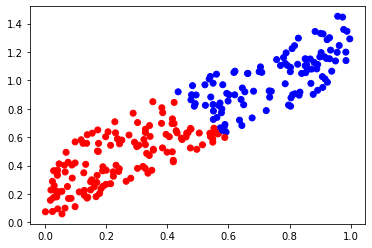

In [32]:
cov = rbf_kernel(X,X)

mode, log_q = mode_finding_laplace(cov, y, normal_cdf_lf_fn)

#test = generate_dataset(50)

test_x = data[250:,:2]

pi = laplace_predictions(mode, X, y, rbf_kernel, normal_cdf_lf_fn, test_x)




x_1 = test_x[:,0]
x_2 = test_x[:,1]

y = np.array(pi)

y[y>0.5] = 1
y[y<=0.5] = -1
plt.scatter(x_1,x_2,c=y,cmap=matplotlib.colors.ListedColormap(['red', 'blue']))

## Expectation Propagation

In [39]:
def EP(cov, y, max_iters=10):
       
    nu = np.zeros_like(y)
    tau = np.zeros_like(y)
    sigma = np.copy(cov)
    mu = np.zeros_like(y)
    
    tau_cav = np.zeros_like(y)
    nu_cav = np.zeros_like(y)
    
    print(y.shape[0])
    for j in range(max_iters):
        for i in range(y.shape[0]):
            #approximate cavity parameters
            tau_cav[i] = sigma[i,i]**-1 - tau[i]
            nu_cav[i] = (sigma[i,i]**-1)*mu[i] - nu[i]
            # marginal moments marg_mu_i and marg_sigma_i
            sigma_cav = tau_cav[i]**-1
            mu_cav = sigma_cav * nu_cav[i]
            
            z_i = (y[i]*mu_cav)/(1+sigma_cav)**1/2
            print(z_i)
            print(mu_cav)
            print(sigma_cav)
            marg_mu_i = mu_cav + (y[i]*sigma_cav*norm.pdf(z_i))/(norm.cdf(z_i)*(1+sigma_cav)**1/2)
            marg_sigma_i = sigma_cav - (sigma_cav**2 * norm.pdf(z_i)) \
                            *(z_i + (norm.pdf(z_i))/(norm.cdf(z_i))) / ((1 + sigma_cav) * norm.cdf(z_i))
            
            # update site parameters
            delta_tau = marg_sigma_i**-1 - tau_cav[i] - tau[i]
            tau[i] += delta_tau
            nu[i] = marg_sigma_i**-1 * marg_mu_i - nu_cav[i]
            
            # update mu and sigma
#             print(delta_tau)
#             print(sigma[i,i])
#             print(((delta_tau)**-1 + sigma[i,i])**-1)
#             print(sigma[i,:] @ sigma[i,:].T)
            sigma -= ((delta_tau)**-1 + sigma[i,i])**-1 * sigma[:,i] @ sigma[:,i].T
            mu = sigma @ nu
        
        #recompute the approximate posterior parameters
        S = np.diag(tau)
        L = np.linalg.cholesky(np.eye(y.shape[0]) + S**1/2 @ cov @ S**1/2)
        V = np.linalg.solve(L,S**1/2 @ cov)
        sigma = cov - V.T @ V
        mu = sigma @ nu
    
    #calculate approximate log marginal likelihood
    logZ_EP = 0
    logZ_EP += 1/2 * np.sum(np.log(1 + tau.dot(tau_cav))) - np.sum(np.log(np.diag(L)))
    logZ_EP += 1/2 * nu.T @ (cov - cov@S**1/2 @ np.linalg.inv(L)@np.linalg.inv(L.T) @ S**1/2 @ cov \
                               - np.linalg.inv(np.diag(tau_cav) + np.linalg.inv(S)))@ nu
    logZ_EP += 1/2 * (np.linalg.inv(S) @ nu_cav).T @ np.diag(tau_cav) @ np.linalg.inv(S + np.diag(tau_cav))@(S@(np.linalg.inv(S) @ nu_cav) - 2*nu)
    logZ_EP += np.sum([np.log(norm.cdf(y[i]*(tau_cav[i]**-1 * nu_cav[i]) / (1 + tau_cav[i]**-1)**1/2)) for i in range(y.shape[0])])
            
    
    return nu, tau, logZ_EP

In [54]:
def EP_predictions(nu,tau,X,y,cov_fn,x_star):
    
    I_n = np.eye(y.shape[0])
    S = np.diag(tau)
    K = cov_fn(X,X)
    L = np.linalg.cholesky(I_n + S**1/2 @ K @ S**1/2)
    z = S**1/2 @ np.linalg.solve(L.T,np.linalg.solve(L, S**1/2@K@nu))
    f_star = cov_fn(x_star,X).T @ (nu - z)
    
    print(f_star.shape)
    v = np.linalg.solve(L, (S**1/2)@cov_fn(x_star,X))
    print(L.shape)
    print(S.shape)
    print(cov_fn(x_star,X).shape)
    print((S**1/2)@cov_fn(x_star,X).shape)
    print(v.shape)
    var_f_star = cov_fn(x_star,x_star) - v.T@v
    print(var_f_star.shape)
    pi_star = norm.cdf(f_star / (1+var_f_star)**1/2)
    
    return pi_star

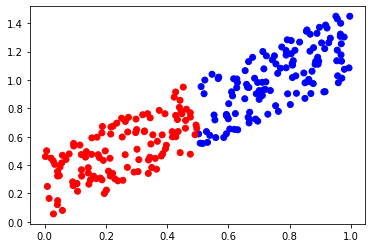

In [46]:
data = generate_dataset(500)
x_1 = data[:250,0]
x_2 = data[:250,1]
X = data[:250,:2]
y = data[:250,2]
y[y==0] = -1
plt.scatter(x_1,x_2,c=y,cmap=matplotlib.colors.ListedColormap(['red', 'blue']))

[[1.         0.72648638]
 [0.72648638 1.        ]]
(2, 2)
2
0.0
0.0
1.0
0.09285794454941783
0.2811166073025658
0.5136917399294743
0.2998454463605917
1.5647229103656073
1.6092157298995367
0.34100813372923083
2.4324736733814514
2.566591868029895
0.2511258665021938
1.2164793174108024
1.4220510104246376
0.2422423432909465
1.0792874624830977
1.2277019116901737
0.26871238874057685
1.316066336801806
1.4488382224765537
0.2708150448030098
1.3616119428605347
1.5139148821125652
0.26337188390354016
1.2874996235567708
1.4442617117556806
0.2628131560063458
1.2756283832726596
1.4268731494588092
0.2648325142463963
1.2951659207544814
1.4452547385278343
0.2649771805875175
1.2983942469417757
1.4500114388396135
0.2644344182455019
1.2930970799429844
1.4450241548028526
0.26439597577765767
1.2922359637085874
1.4437511953572357
0.26454112567157617
1.29364983769242
1.4450826585248349
0.26455133441312617
1.2938799335866598
1.4454231849878387
0.26451258418027956
1.2935022177347908
1.445067446872772
0.26450986488

ValueError: 'c' argument has 4 elements, which is inconsistent with 'x' and 'y' with size 2.

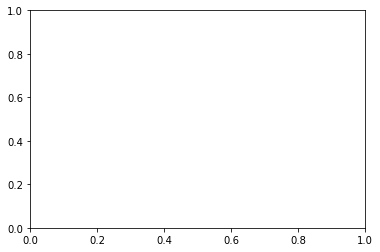

In [55]:
data = generate_dataset(4)
x_1 = data[:2,0]
x_2 = data[:2,1]
X = data[:2,:2]
y = data[:2,2]
y[y==0] = -1


cov = rbf_kernel(X,X)


print(cov)
print(cov.shape)
nu, tau, logZ_EP = EP(cov, y)

#test = generate_dataset(50)

test_x = data[2:,:2]

print(nu)
print(tau)
print(logZ_EP.shape)
pi = EP_predictions(nu, tau, X, y, rbf_kernel, test_x)




x_1 = test_x[:,0]
x_2 = test_x[:,1]

y = np.array(pi)

y[y>0.5] = 1
y[y<=0.5] = -1
plt.scatter(x_1,x_2,c=y,cmap=matplotlib.colors.ListedColormap(['red', 'blue']))